This is the second part of training a model for facial emotion classification. In the [first part](https://www.kaggle.com/code/harshit1234g/facial-emotion-classification) I tried several CNN architectures like VGGNet, ResNet, etc and trained them myself. In this part I'll use pretrained keras models and transfer learning to make better models.

In [1]:
import tensorflow as tf

## Loading Dataset
[Dataset Link](https://www.kaggle.com/datasets/msambare/fer2013)

In [2]:
train_path = r'/kaggle/input/fer2013/train'
test_path = r'/kaggle/input/fer2013/test'
CLASS_NAMES = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
IMG_SHAPE = 48

In [3]:
train_dataset, validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(   # it is optimized for large dataset
    train_path,
    label_mode= 'categorical',
    color_mode= 'rgb',     # because VGG Net (pretrained) needs data with 3 color channels
    class_names= CLASS_NAMES,
    shuffle= True,
    seed= 42,
    validation_split= 0.1,
    subset= 'both',
    image_size= (IMG_SHAPE, IMG_SHAPE)
)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    label_mode= 'categorical',
    color_mode= 'rgb',
    class_names= CLASS_NAMES,
    shuffle= True,
    seed= 42,
    image_size= (IMG_SHAPE, IMG_SHAPE)
)

Found 28709 files belonging to 7 classes.
Using 25839 files for training.
Using 2870 files for validation.
Found 7178 files belonging to 7 classes.


## Data Augmentation

In [4]:
# using this because it is GPU accelerated
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode= 'horizontal'),
    tf.keras.layers.RandomRotation(factor= 0.2),    # [-20% * 2pi, 20% * 2pi]
    tf.keras.layers.RandomBrightness(factor= 0.1)   # only slightly darken or brighten the image
])


def augment_data(image: tf.Tensor, label: tf.Tensor) -> tuple[tf.Tensor, ...]:
    aug_img = data_augmentation(image)
    return aug_img, label


# generating augmented images
augmented_dataset = train_dataset.map(augment_data)

## Dataset Preparation

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = (
    train_dataset
    .concatenate(augmented_dataset)    # concatenating both train and augmented datasets
    .shuffle(buffer_size= 100)         # shuffling so that one batch will have both augmented and normal images
    .prefetch(buffer_size= AUTOTUNE)   # prefetching to making training faster
)
validation_dataset = validation_dataset.prefetch(buffer_size= AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size= AUTOTUNE)

## Using Pretrained Models from Keras for Transfer Learning
**Transfer Learning:**
- A technique to reuse models trained on large dataset (fully or partially) for a related task.
- We fine-tune a pretrained model for our specific task.
- The lower layers capture general image features like edges, textures and shape.
- Upper layers capture more specific details related to dataset.
- Reuses the lower layers and modify or replaces upper layers for out task.

For more details checkout [Transfer learning and fine-tuning](https://www.tensorflow.org/tutorials/images/transfer_learning). For now I'm trying 6 different models:

### 1. [VGG-19](https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG19)

In [6]:
vgg_19_base_model = tf.keras.applications.VGG19(
    include_top= False, 
    input_shape= (IMG_SHAPE, IMG_SHAPE, 3)
)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
preprocess_inputs = tf.keras.applications.vgg19.preprocess_input

In [8]:
vgg_19_base_model.trainable = False

In [9]:
vgg_19_base_model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [10]:
global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()

In [12]:
dense_network = tf.keras.layers.Dense(1024, activation= 'relu', kernel_initializer= 'he_normal')

In [13]:
prediction_layer = tf.keras.layers.Dense(7, activation= 'softmax')

In [14]:
inputs = tf.keras.layers.Input(shape= (IMG_SHAPE, IMG_SHAPE, 3))
x = preprocess_inputs(inputs)
x = vgg_19_base_model(x)
x = global_avg_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = dense_network(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [15]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 48, 48, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 48, 48)         │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 48, 48)         │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 48, 48)         │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 48, 48, 3)      │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 48, 48, 3)      │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg19 (Functional)        │ (None, 1, 1, 512)      │     20,024,384 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 512)            │              0 │ vgg19[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512)            │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1024)           │        525,312 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 1024)           │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 7)              │          7,175 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 20,556,871 (78.42 MB)

 Trainable params: 532,487 (2.03 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [16]:
model.trainable_variables

[<KerasVariable shape=(512, 1024), dtype=float32, path=dense/kernel>,
 <KerasVariable shape=(1024,), dtype=float32, path=dense/bias>,
 <KerasVariable shape=(1024, 7), dtype=float32, path=dense_1/kernel>,
 <KerasVariable shape=(7,), dtype=float32, path=dense_1/bias>]

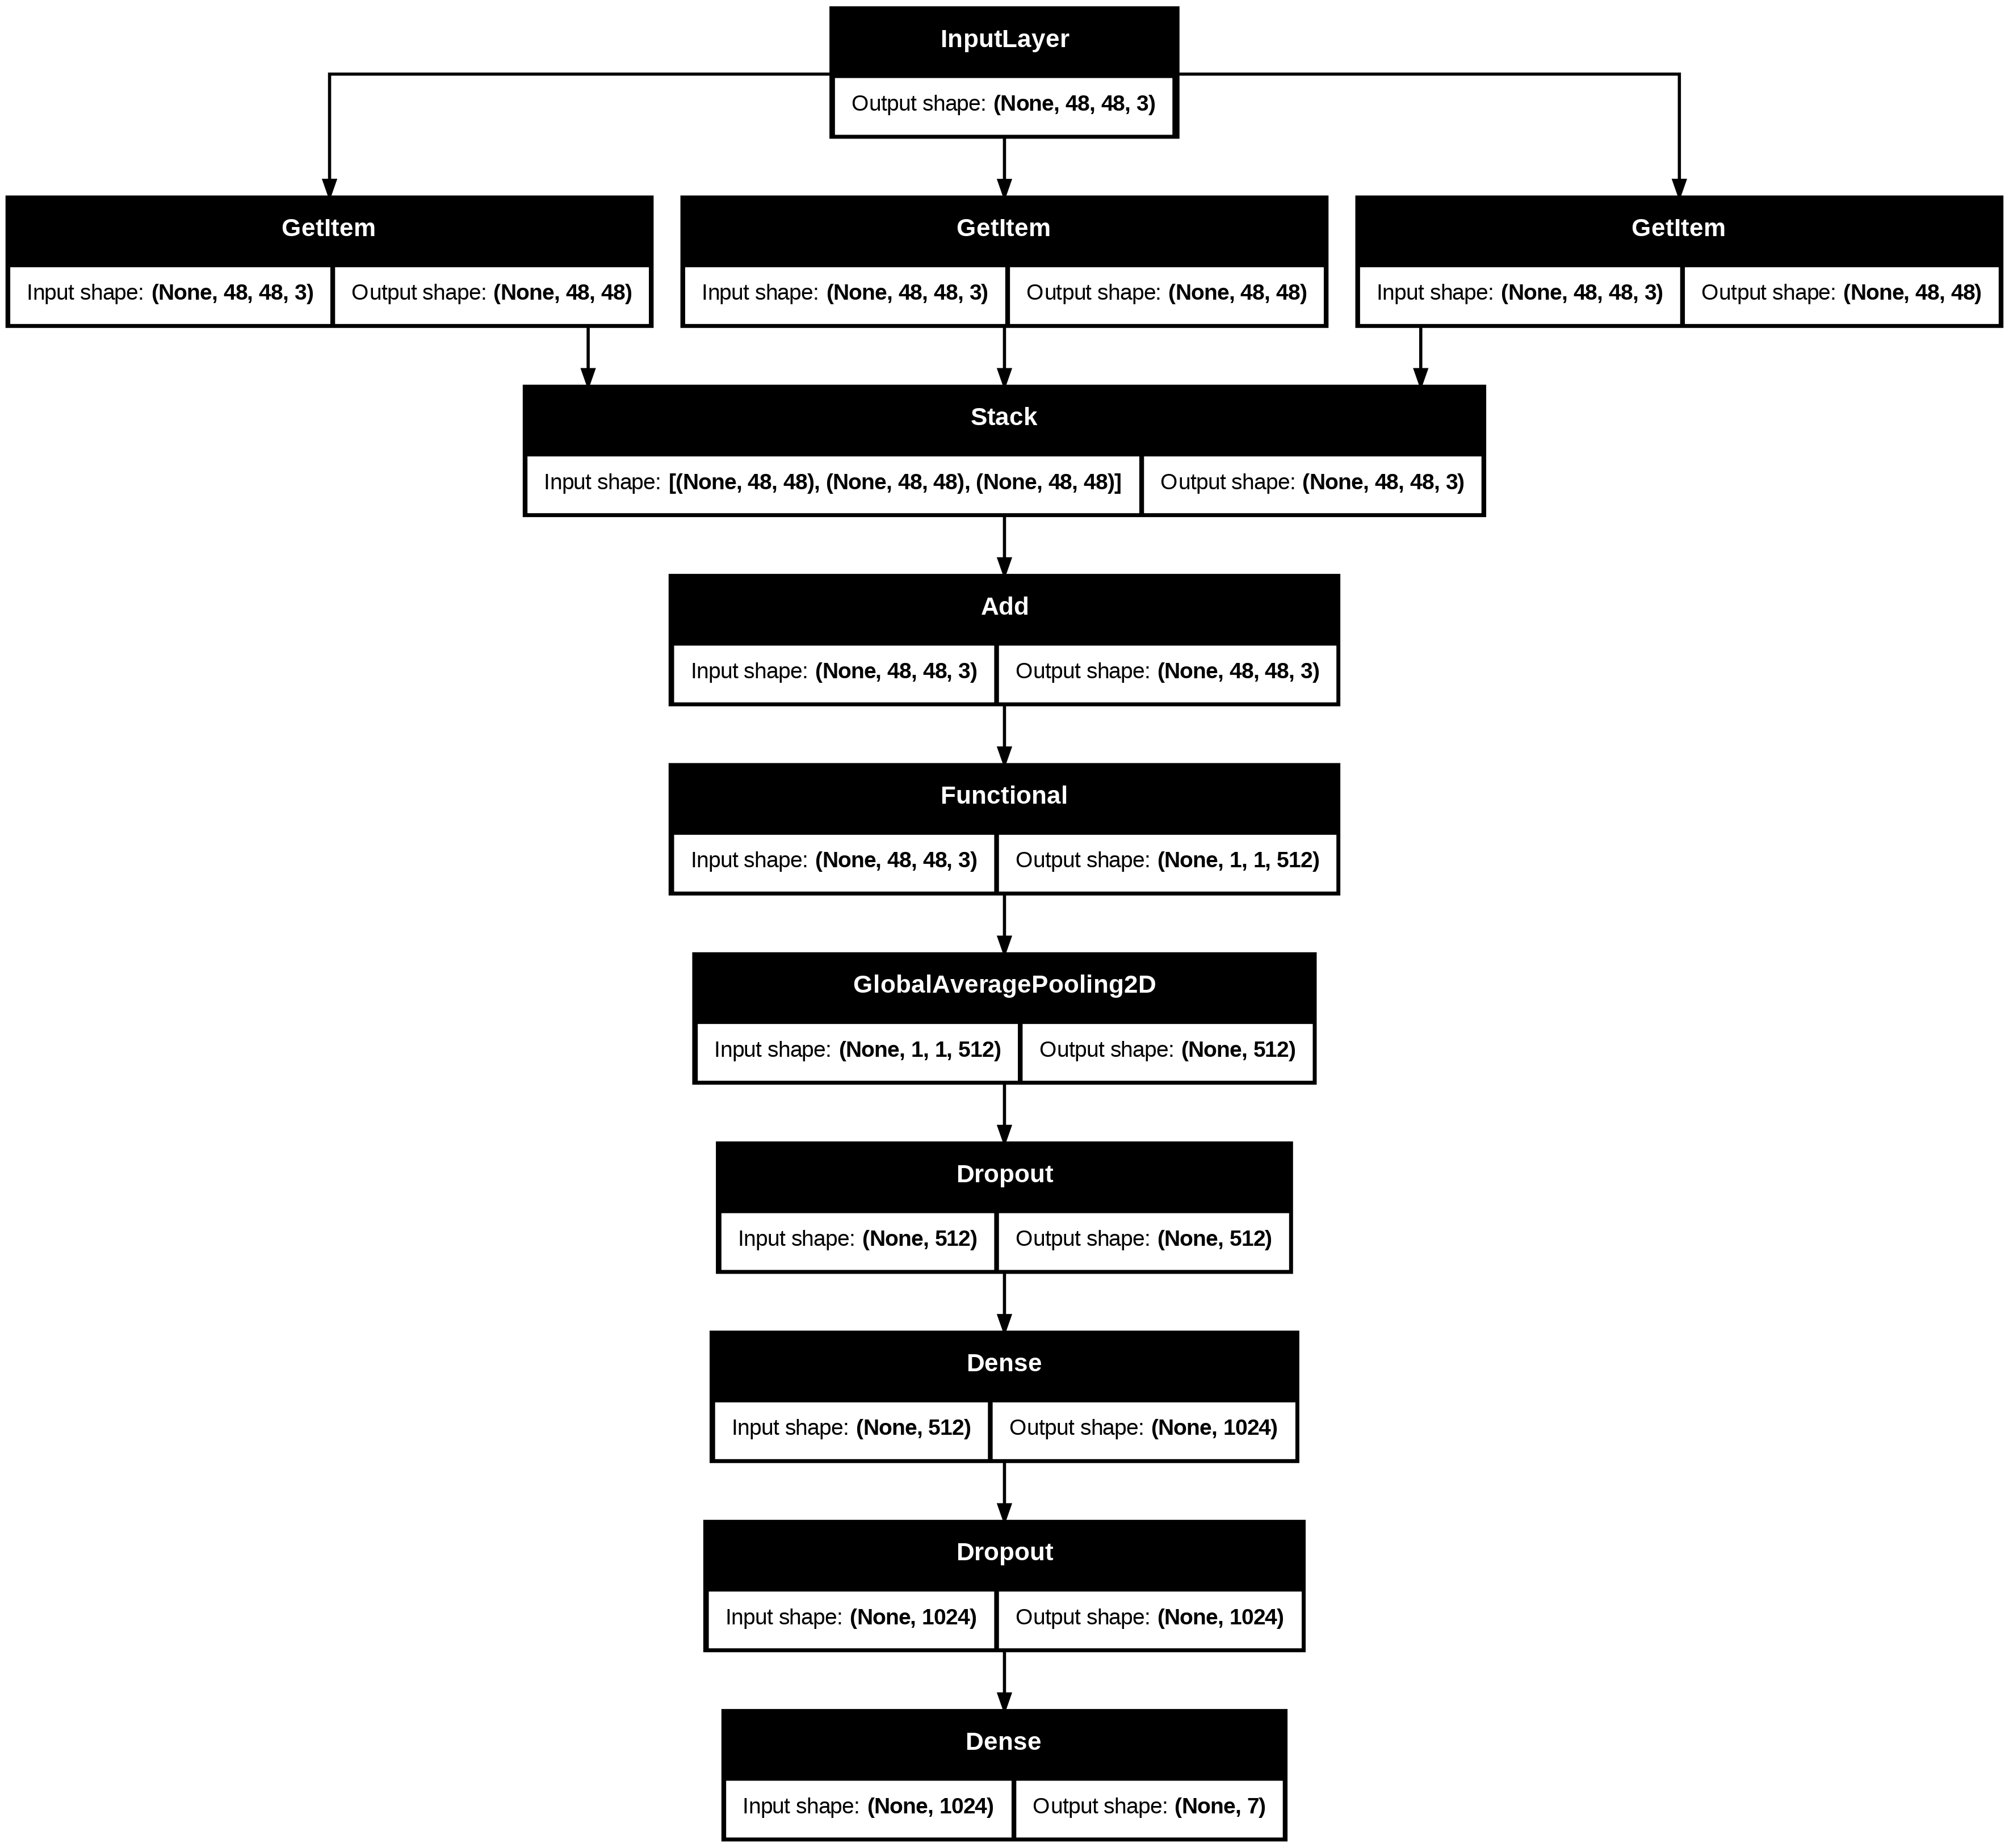

In [18]:
tf.keras.utils.plot_model(model, show_shapes= True)

In [19]:
model.compile(
    loss= 'categorical_crossentropy',
    optimizer= tf.keras.optimizers.Adam(learning_rate= 1e-4),
    metrics= ['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(name= 'top_k')]
)

In [20]:
loss, acc, top_k = model.evaluate(validation_dataset)

90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.1958 - loss: 25.2148 - top_k: 0.7314


In [21]:
def create_callbacks(name: str, *, es_patience: int = 5) -> list[tf.keras.callbacks.Callback]:
    tensorboard_cb = tf.keras.callbacks.TensorBoard(f'/kaggle/working/logs/{name}')
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        patience= es_patience, 
        restore_best_weights= True
    )
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        f'{name}.weights.h5', 
        save_weights_only= True,
        save_best_only= True
    )
    return [tensorboard_cb, early_stopping, checkpoint_cb]

In [22]:
model.fit(
    train_dataset,
    epochs= 50,
    validation_data= validation_dataset,
    callbacks= create_callbacks('vgg_19_tl')
)

Epoch 1/50
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 37s 19ms/step - accuracy: 0.2323 - loss: 15.6625 - top_k: 0.8524 - val_accuracy: 0.3446 - val_loss: 4.9449 - val_top_k: 0.9084
Epoch 2/50
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.2641 - loss: 7.8578 - top_k: 0.8769 - val_accuracy: 0.3261 - val_loss: 3.0974 - val_top_k: 0.9160
Epoch 3/50
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.2780 - loss: 4.6511 - top_k: 0.8918 - val_accuracy: 0.3314 - val_loss: 2.1371 - val_top_k: 0.9164
Epoch 4/50
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.2934 - loss: 2.8667 - top_k: 0.9013 - val_accuracy: 0.3341 - val_loss: 1.7547 - val_top_k: 0.9139
Epoch 5/50
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.3093 - loss: 2.0756 - top_k: 0.9089 - val_accuracy: 0.3488 - val_loss: 1.6744 - val_top_k: 0.9223
Epoch 6/50
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.3346 - loss: 1.7764 - top_k: 0.9233 - val_accuracy: 0.3571 - val_loss: 1.6445 - val_top_k

## I'll be back to this after exams.